This notebook computes single-trial power spectra and fits FOOOF model over them. Single-trial time constant parameters are extracted, as well as other spectral parameters (exponent, offset, theta & HG powers, etc). Group aggregating, statistics, and visualizations are in `./4_viz_human_wm.ipynb.`

In [1]:
%load_ext autoreload
%matplotlib inline

import hdf5storage # you need to pip install this to handle matlab > 7.3 files or something
import numpy as np
from fooof import FOOOFGroup, fit_fooof_group_3d
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import sys
sys.path.append('../')
from echo_utils import makedir, convert_knee_val

import warnings
warnings.filterwarnings('ignore')

********************************************************************************
         to build the TVTK classes (8.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



In [2]:
data_folder = '/Users/rdgao/Documents/data/CRCNS/Johnson/'
result_basepath = '/Users/rdgao/Documents/code/research/field-echos/results/johnson/'
df_patient_info = pd.read_csv(data_folder+'patient_info_combined.csv', index_col=0)
df_electrode_info = pd.read_csv(data_folder+'electrode_info_combined.csv')

# save metadata to saved data folder for easier access
df_patient_info.to_csv('../data/df_johnson_patient_info.csv')
df_electrode_info.to_csv('../data/df_johnson_electrode_info.csv')

# get all subjects
all_subjs = df_patient_info.index.values.astype(str)

# there are the three datatypes in the mat file
data_types = ['data_pre', 'data_encmain', 'data_proc']
n_types = np.shape(data_types)[0]

# these are the time windows Johnson et al. used
# note that I'm keep all the windows 900ms so the knee-fits are all using the same amount of data
# but we will average taus from the two delay periods since we just want to check delay versus pre-stim
trial_time_wins = [[0.0, 0.9], [0.6, 1.5], [0.3, 1.2]]

# FOOOF settings
freq_range = [2, 80] # this is the range gao uses
bw_lims = [2, 8]
max_n_peaks = 2 # single-trial fits are so noisy so this isn't super critical

### Compute and Save PSDs

In [3]:
### processing only frontal channels
# for i_sub, sub in enumerate(all_subjs):
#     print(sub, end=' |')
#     # load data file
#     filepath = data_folder + sub + '/data_derived.mat'
#     mat = hdf5storage.loadmat(filepath)

#     # get subject-specific sampling rate
#     fs = df_patient_info.loc[sub]['sampling_rate']
    
#     chan_names = np.squeeze(mat[data_types[0]]['label'].tolist()).tolist() # full list of channels
#     frontal_chans = df_electrode_info[(df_electrode_info['patient']==sub) & ((df_electrode_info['region']=='PFC') | (df_electrode_info['region']=='OFC'))]['electrode'].values.astype(str)
#     n_chans = np.shape(frontal_chans)[0] # number of PFC+OFC channels

#     # find indices of frontal channels in full channel list
#     chans_idx = [chan_names.index(chan) for chan in frontal_chans]

#     # get the number of trials, for initializing data arrays
#     n_trials = np.shape(np.squeeze(mat[data_types[0]]['trial']))[0]

#     # get time vector from data matrix
#     t = np.asarray(np.squeeze(mat[data_types[0]]['time'].tolist()).tolist()[0])

#     power_spec_all = []
#     for i_cond in range(len(data_types)):
#         # restrict to proper time windows for this condition
#         period_idx = [np.where(t>=trial_time_wins[i_cond][i_period])[0][0] for i_period in range(2)]

#         # grab condition data and gather only the relevant time points & channels
#         cond_data = np.squeeze(mat[data_types[i_cond]]['trial']).tolist()

#         # here, trial_data.shape = trial x channel x time
#         trial_data = np.array([cond_data[tr][chans_idx, period_idx[0]:period_idx[1]] for tr in range(n_trials)])
#         n_points = trial_data.shape[2] # of timepoints in trial

#         # mean-subtract from time average per trial, and apply hamming window
#         data_windowed = (trial_data-trial_data.mean(2)[:,:,None])*np.hamming(n_points)

#         # compute freq vector and single-trial power spectra
#         f_axis = np.fft.rfftfreq(n_points, 1/fs)
#         power_spec = np.abs(np.fft.rfft(data_windowed))**2
#         power_spec_all.append(power_spec)

#     # merge across trials and save
#     # power_spec_all.shape here is [cond x trial x channel x freq]
#     power_spec_all = np.array(power_spec_all)
#     save_dict = dict((name,eval(name)) for name in ['f_axis','power_spec_all', 'frontal_chans', 'fs'])
#     saveout_path = makedir(result_basepath, sub, timestamp=False)
#     np.savez(file=saveout_path+'/psd.npz', **save_dict)

s1 |s2 |s3 |s4 |s5 |s6 |s7 |s8 |s9 |s10 |s11 |s12 |s13 |s14 |s15 |s16 |s17 |

# Process all channels

In [5]:
for i_sub, sub in enumerate(all_subjs):
    print(sub, end=' |')
    # load data file
    filepath = data_folder + sub + '/data_derived.mat'
    mat = hdf5storage.loadmat(filepath)

    # get subject-specific sampling rate
    fs = df_patient_info.loc[sub]['sampling_rate']    
    
    # get analyzed channels and respective regions
    chan_names = np.squeeze(mat[data_types[0]]['label'].tolist()).tolist() # full list of channels
    selected_chans = df_electrode_info[(df_electrode_info['patient']==sub)]['electrode'].values.astype(str)
    selected_regions = df_electrode_info[(df_electrode_info['patient']==sub)]['region'].values.astype(str)
    chans_idx = [chan_names.index(chan) for chan in selected_chans]    
    
    # get the number of trials, for initializing data arrays
    n_trials = np.shape(np.squeeze(mat[data_types[0]]['trial']))[0]

    # get time vector from data matrix
    t = np.asarray(np.squeeze(mat[data_types[0]]['time'].tolist()).tolist()[0])

    power_spec_all = [] 
    for i_cond in range(len(data_types)):
        # restrict to proper time windows for this condition
        period_idx = [np.where(t>=trial_time_wins[i_cond][i_period])[0][0] for i_period in range(2)]

        # grab condition data and gather only the relevant time points & channels
        cond_data = np.squeeze(mat[data_types[i_cond]]['trial']).tolist()

        # here, trial_data.shape = trial x channel x time
        trial_data = np.array([cond_data[tr][chans_idx, period_idx[0]:period_idx[1]] for tr in range(n_trials)])
        n_points = trial_data.shape[2] # of timepoints in trial

        # mean-subtract from time average per trial, and apply hamming window
        data_windowed = (trial_data-trial_data.mean(2)[:,:,None])*np.hamming(n_points)

        # compute freq vector and single-trial power spectra
        f_axis = np.fft.rfftfreq(n_points, 1/fs)
        power_spec = np.abs(np.fft.rfft(data_windowed))**2
        power_spec_all.append(power_spec)

    # merge across trials and save
    # power_spec_all.shape here is [cond x trial x channel x freq]
    power_spec_all = np.array(power_spec_all)
    save_dict = dict((name,eval(name)) for name in ['f_axis','power_spec_all', 'selected_chans', 'selected_regions', 'fs'])
    saveout_path = makedir(result_basepath, sub, timestamp=False)
    np.savez(file=saveout_path+'/psd.npz', **save_dict)

s1 |s2 |s3 |s4 |s5 |s6 |s7 |s8 |s9 |s10 |s11 |s12 |s13 |s14 |s15 |s16 |s17 |

### Load PSDs and FOOOF away!

In [6]:
save_dir = '../data/johnson/'
offset_all, knee_all, tau_all, exp_all = [], [], [], []
offset_tavg, knee_tavg, tau_tavg, exp_tavg = [], [], [], []

for i_sub, sub in enumerate(all_subjs):
    print(sub, end='| ')
    psd_data = np.load(result_basepath+sub+'/psd.npz')
    power_spec_all = psd_data['power_spec_all']
    f_axis = psd_data['f_axis']
        
    # single trial fits
    ap_params_all = []
    for i_cond in range(power_spec_all.shape[0]):
        ap_params_cond = []
        for chan in range(power_spec_all.shape[2]):            
            # fit all trials in a channel
            fg = FOOOFGroup(peak_width_limits=bw_lims, aperiodic_mode='knee', max_n_peaks=max_n_peaks, verbose=False)
            fg.fit(f_axis, power_spec_all[i_cond, :, chan, :], freq_range=freq_range)
            # grab aperiodic parameter fits
            ap_chan = np.ones((len(fg.get_results()), 3))*np.nan
            for i_r, res in enumerate(fg.get_results()):
                # loop through to catch non-fits
                if type(res.aperiodic_params) is not type(None):
                    ap_chan[i_r, :] = res.aperiodic_params

            # stuff into list
            ap_params_cond.append(ap_chan)

        # stuff list into a list
        ap_params_all.append(np.array(ap_params_cond))
    
    # turn into array and separate parameters
    ap_params_all = np.array(ap_params_all)
    print(ap_params_all.shape)

    # compute knee freq & time constant
    _, tau = convert_knee_val(ap_params_all[:,:,:,1], ap_params_all[:,:,:,2])        
    tau_all.append(tau)
    offset_all.append(ap_params_all[:,:,:,0])
    knee_all.append(ap_params_all[:,:,:,1])
    exp_all.append(ap_params_all[:,:,:,2])

# save data
with open(save_dir+"all_exp.txt", "wb") as fp: # pickling
    pickle.dump(exp_all, fp)
with open(save_dir+"all_offset.txt", "wb") as fp: # pickling
    pickle.dump(offset_all, fp)
with open(save_dir+"all_knee.txt", "wb") as fp: # pickling
    pickle.dump(knee_all, fp)
with open(save_dir+"all_tau.txt", "wb") as fp: # pickling
    pickle.dump(tau_all, fp)


s1| (3, 15, 111, 3)
s2| (3, 25, 113, 3)
s3| (3, 7, 115, 3)
s4| (3, 19, 118, 3)
s5| (3, 28, 120, 3)
s6| (3, 48, 108, 3)
s7| (3, 24, 100, 3)
s8| (3, 9, 90, 3)
s9| (3, 27, 120, 3)
s10| (3, 52, 116, 3)
s11| (3, 23, 120, 3)
s12| (3, 32, 120, 3)
s13| (3, 68, 120, 3)
s14| (3, 17, 120, 3)
s15| (3, 26, 120, 3)
s16| (3, 12, 101, 3)
s17| (3, 9, 90, 3)


### Load PSDs and compute power features

In [7]:
theta_freqs, hfa_freqs = [3, 8], [70, 100]

save_dir = '../data/johnson/'
theta_all, hfa_all, = [], []

for i_sub, sub in enumerate(all_subjs):
    # load data
    print(sub, end='| ')
    psd_data = np.load(result_basepath+sub+'/psd.npz')
    power_spec_all = psd_data['power_spec_all']
    f_axis = psd_data['f_axis']    

    # get freq indices of theta and HFA bands
    inds_theta = np.logical_and(f_axis>=[theta_freqs[0]], f_axis<=[theta_freqs[1]])
    inds_hfa = np.logical_and(f_axis>=[hfa_freqs[0]], f_axis<=[hfa_freqs[1]])


    # get mean log-power in theta and HFA bands
    theta_all.append(np.log10(power_spec_all[:,:,:,inds_theta]).mean(-1))
    hfa_all.append(np.log10(power_spec_all[:,:,:,inds_hfa]).mean(-1))

# save data
with open(save_dir+"all_theta.txt", "wb") as fp: # pickling
    pickle.dump(theta_all, fp)
with open(save_dir+"all_hfa.txt", "wb") as fp: # pickling
    pickle.dump(hfa_all, fp)


s1| s2| s3| s4| s5| s6| s7| s8| s9| s10| s11| s12| s13| s14| s15| s16| s17| 

In [26]:
reg, reg_inds = np.unique(psd_data['selected_regions'],return_inverse=True)
b

array([0, 0, 0, 0, 1, 1, 1, 1, 1])

### Load data and plot PSDs

In [29]:
(reg_inds==0)

array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

s1| s2| s3| s4| s5| s6| s7| s8| s9| s10| s11| s12| s13| s14| s15| s16| s17| 

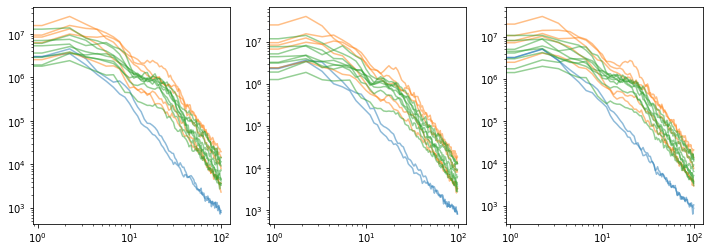

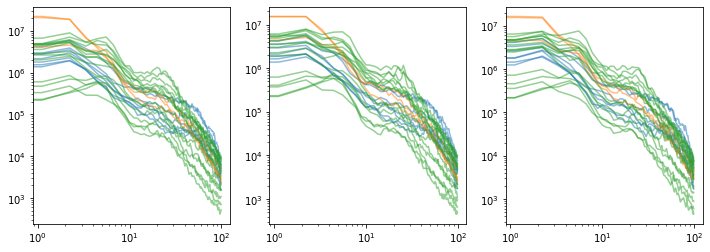

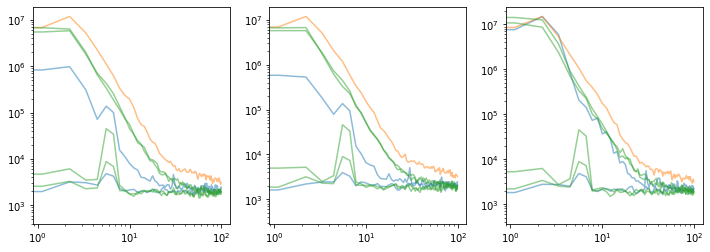

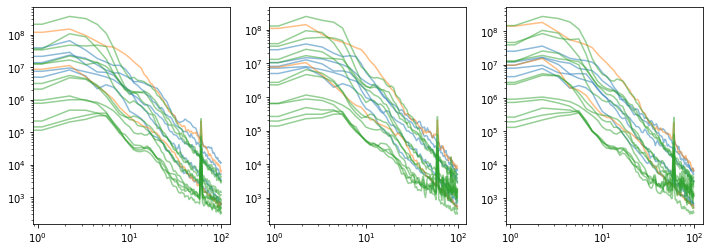

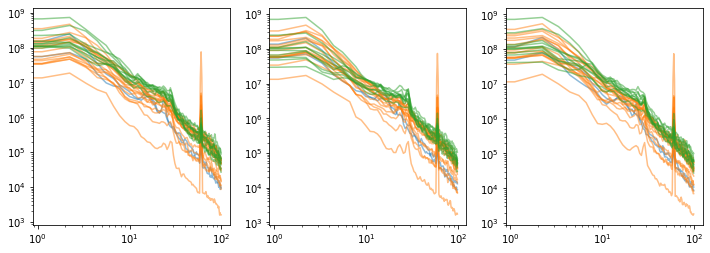

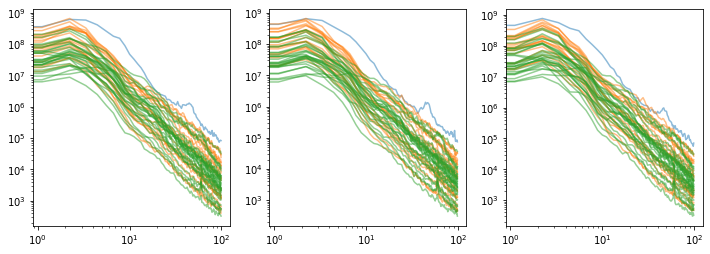

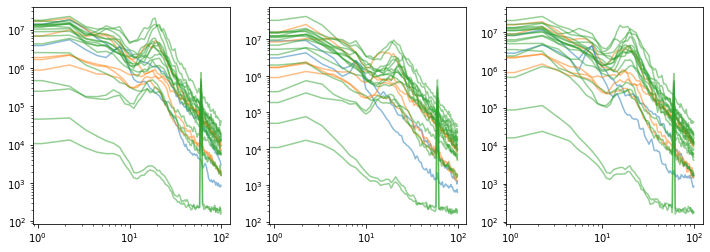

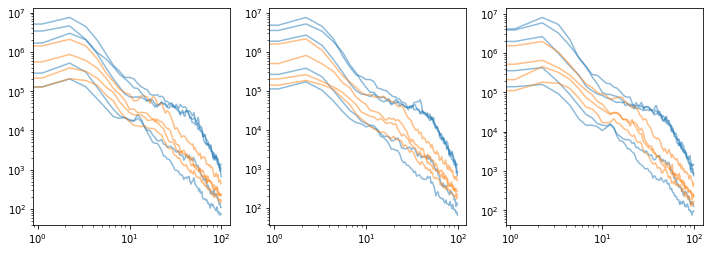

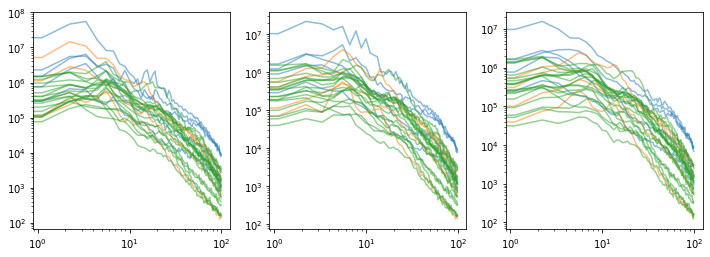

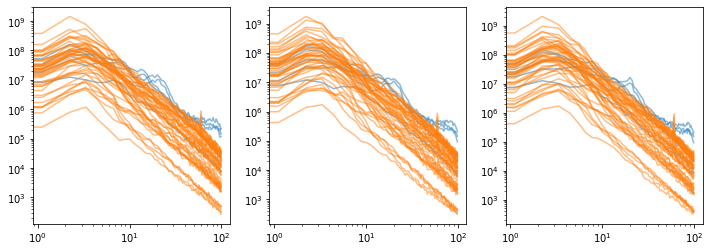

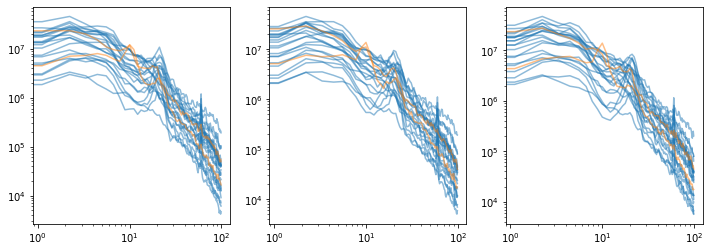

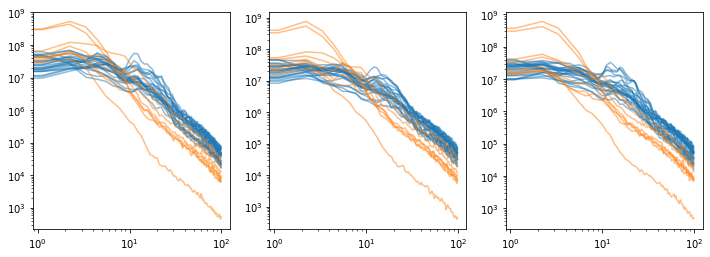

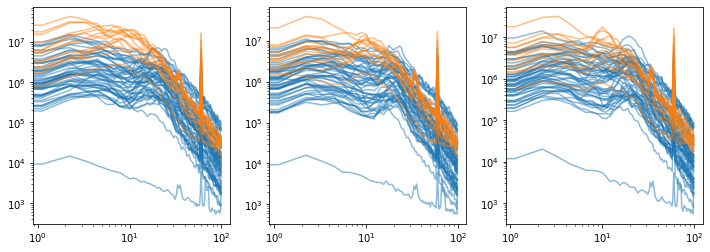

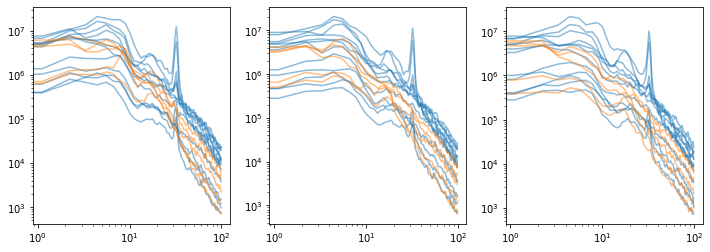

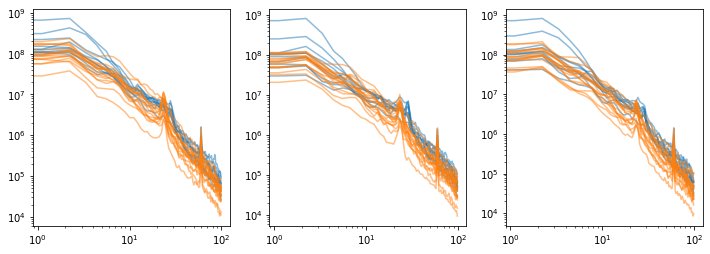

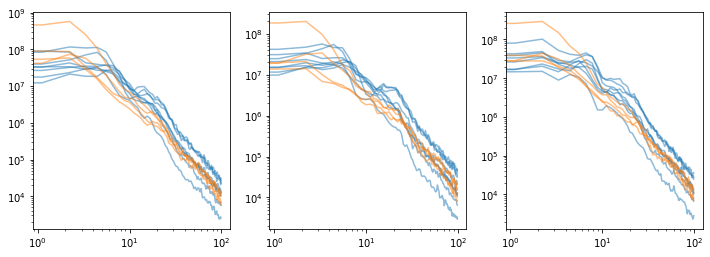

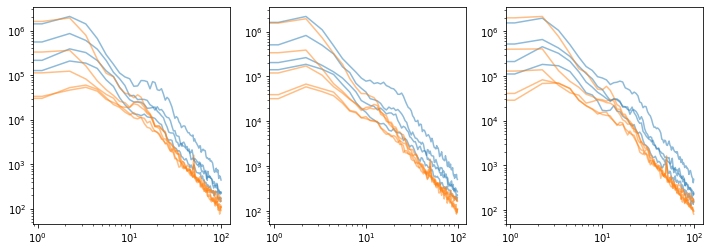

In [34]:
C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i_sub, sub in enumerate(all_subjs):
    # load data
    print(sub, end='| ')
    psd_data = np.load(result_basepath+sub+'/psd.npz')
    power_spec_all = psd_data['power_spec_all']
    f_axis = psd_data['f_axis']    

    plt.figure(figsize=(12,4))
    for i in range(3):
        plt.subplot(1,3,i+1)
        reg, reg_inds = np.unique(psd_data['selected_regions'],return_inverse=True)
        for i_r, r in enumerate(reg):
            #plt.loglog(f_axis[:90], power_spec_all.mean(1)[i,:,:90].T, 'k-', alpha=0.5);
            plt.loglog(f_axis[:90], power_spec_all.mean(1)[i,reg_inds==i_r,:90].T, color=C_ORD[i_r], alpha=0.5, label=r);

S3 data is definitely screwed up.

In [7]:
def get_fg_ap(fg, fill=None):
    if fill is None:
        fill = np.nan
    # grab aperiodic parameter fits    
    ap_collect = np.ones((len(fg), 3 if fg.aperiodic_mode is 'knee' else 2))*fill
    for i_r, res in enumerate(fg.get_results()):
        # loop through to catch non-fits
        if type(res.aperiodic_params) is not type(None):
            ap_collect[i_r, :] = res.aperiodic_params
    
    return ap_collect
